In [1]:
import os, sys, time, resource, re, gc, shutil
from multiprocess import Pool
from functools import partial
from tabulate import tabulate
from urllib.parse import urlparse, parse_qsl

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from mongoengine.queryset.visitor import Q
import django
from django.db.models import Count, Sum
sys.path.append('/home/galm/software/django/tmv/BasicBrowser/')
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
django.setup()

from django.forms.models import model_to_dict

from scoping.models import *
from tmv_app.models import *
from scipy import stats
import ipy_table as tbl

run_id = 359
qid = 1603

In [2]:
docs = Doc.objects.filter(query=qid)

In [3]:
calc_sizes = False
if calc_sizes:
    topic_sizes = {}
    docs = Doc.objects.filter(query=qid,doctopic__isnull=False).distinct('UT')
    for doc in docs.iterator():
        t = doc.doctopic_set.filter(run_id=run_id).order_by('-score').first()
        try:
            topic_sizes[t.topic.title] +=1
        except:
            topic_sizes[t.topic.title] = 1

    print(topic_sizes)

    for key in topic_sizes:
        print(key)
        value = topic_sizes[key]
        topic = Topic.objects.get(run_id=run_id,title=key)
        topic.size = value
        print(topic.size)
        topic.save()

In [14]:
topic_sizes = list(Topic.objects.filter(run_id=run_id).values('title','size'))
topics = pd.DataFrame.from_dict(list(topic_sizes)).rename(columns={'title':'topic','size':'topic_size'})
topics.head()

,topic_size,topic
0,None,"{build, energi, perform}"
1,None,"{transit, rail, station}"
2,None,"{thermal, comfort, temperatur}"
3,None,"{develop, sustain, govern}"
4,None,"{wast, manag, solid}"


In [5]:
tvalues = []
dns = 0
for d in docs:
    
    ns = [x for x in re.findall("[^0-9]+([2-3{1}][0-9]{3})[^0-9]+",d.content) if int(x) > 2017 and int(x) < 2101]
    if len(ns) > 0:
        dns+=1
        t = d.doctopic_set.filter(run_id=run_id).order_by('-score').first()
        #ts = d.doctopic_set.filter(run_id=run_id,score__gt=0.015)
        #for t in ts:
        for n in ns:
            v = {
                "doc" : d.UT,
                "topic" : t.topic.title,
                "topic_size" : t.topic.size,
                "number" : n,
                "abstract": d.content
            }
            tvalues.append(v)
            
print(dns)

361


In [6]:
df = pd.DataFrame.from_dict(list(tvalues))
df['number'] = pd.to_numeric(df['number'])
df.head()
len(df)

477

In [7]:
pdf = df[['topic','number']]
g = pdf.groupby('topic').agg(['median','count']).sort_values(('number','median'))
print(g.head())
g['topic'] = g.index
g = g.reset_index(drop=True)
g['order'] = g.index
g.columns = g.columns.get_level_values(0) + "_" + g.columns.get_level_values(1)
g = g.rename(columns={"topic_":"topic","order_":"order"})


g['topic_label'] = g.apply(lambda x: "{} [{}]".format(x['topic'], (x['number_count'])) , axis=1)

pdf = pd.merge(pdf,g[['topic','order']])
pdf['topic'] = pdf.apply(lambda x: "{:02d} {}".format(x['order'], x['topic']) , axis=1)

                           number      
                           median count
topic                                  
{build, energi, perform}   2020.0    27
{model, network, optim}    2020.0     4
{charg, station, congest}  2025.0     2
{transport, public, car}   2025.0    21
{price, congest, road}     2025.0     4


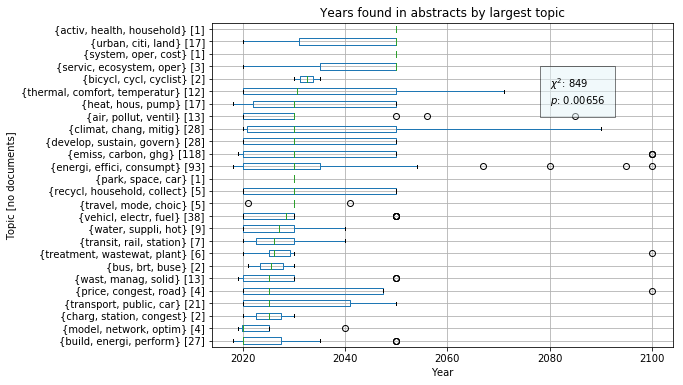

In [8]:
import matplotlib.pyplot as plt
crosstab = pd.crosstab(df['topic'],df['number'])
chi2, p, dof, expected = stats.chi2_contingency(crosstab.values)

#tbl.make_table(results)
plt.rcParams["figure.figsize"] = [8,6]

pdf.boxplot(column='number', by='topic', vert=False)

#plt.setp(bp['boxes'], color='black')

plt.savefig('../plots/topic_years.png',bbox_inches='tight')  

plt.text(
    2080,20,'$\chi^2$: {0:.3g}\n$p$: {1:.3g}'.format(chi2,p),
    bbox={'facecolor':'#e5f5f9', 'alpha':0.5, 'pad':10}
)

plt.title('Years found in abstracts by largest topic')
plt.suptitle('')

#fig, ax = plt.subplots()
plt.yticks(g.index+1,g.topic_label)
plt.xlabel('Year')
plt.ylabel('Topic [no documents]')

#plt.savefig('../plots/topic_years_mixture.png',bbox_inches='tight')
#plt.savefig('../plots/topic_years_mixture.svg',bbox_inches='tight')

plt.show()



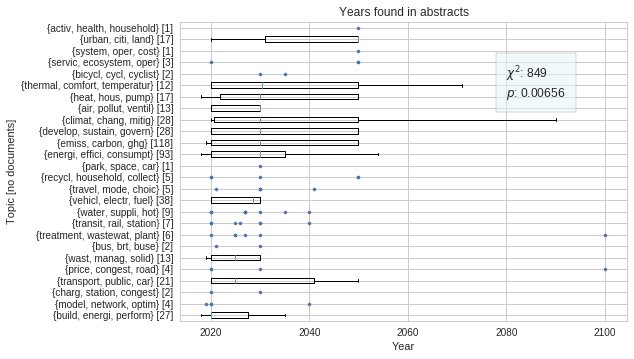

359

In [13]:
pdf3 = pdf.groupby('topic')
i = 1
boxdata = []
pointdata = np.array([])

x = []
y = []

for name, group in pdf3:
    bdat = []
    pdat = []
    if group.count().number > 10:
        bdat = group['number'].values
    else:
        x.extend(group['number'].values)
        y.extend([i]*group.count().number)
        pdat = group['number'].values
    boxdata.append(bdat)
    pointdata = np.append(pointdata,pdat)
    i+=1
plt.boxplot(boxdata,vert=False)

plt.scatter(x,y,s=10)

plt.yticks(g.index+1,g.topic_label)

plt.text(
    2080,20,'$\chi^2$: {0:.3g}\n$p$: {1:.3g}'.format(chi2,p),
    bbox={'facecolor':'#e5f5f9', 'alpha':0.5, 'pad':10}
)

plt.xlabel('Year')
plt.ylabel('Topic [no documents]')
plt.title('Years found in abstracts')
plt.suptitle('')

plt.savefig('../plots/topic_years.png',bbox_inches='tight')
plt.savefig('../plots/topic_years.svg',bbox_inches='tight')


plt.show()

run_id

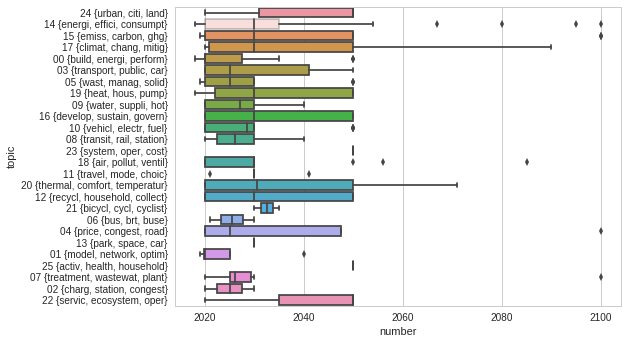

In [10]:
import seaborn as sns

sns.set_style('whitegrid')

ax = sns.boxplot(x="number", y="topic",data=pdf)

plt.setp(ax.artists[1], alpha=.3)

plt.show()

In [11]:
pdf2.columns[0]

NameError: name 'pdf2' is not defined

In [ ]:
df.to_csv("../data/years.csv")

In [ ]:
g = df[['topic','number']].groupby(['topic'], as_index=False)
g = g.agg(['median','mean',np.std, 'count'], as_index=False).rename(columns={'std': 'std dev'}).reset_index()
g.columns = g.columns.get_level_values(0) + "_" + g.columns.get_level_values(1)
g = g.rename(columns={'topic_':'topic'}).sort_values('number_median')

topic_summary = pd.merge(g,topics,how='right')
print(topic_summary)
topic_summary.to_csv("../data/year_summaries.csv")